In [ ]:
#!pip install catboost

In [ ]:
import pandas as pd  # Импорт библиотеки pandas для работы с данными в виде таблиц
from matplotlib import pyplot as plt  # Импорт библиотеки matplotlib для визуализации данных
import numpy as np  # Импорт библиотеки numpy для работы с массивами чисел
from sklearn.model_selection import train_test_split  # Импорт функции train_test_split для разделения данных на обучающий и тестовый наборы
from catboost import CatBoost, CatBoostClassifier  # Импорт классов CatBoost и CatBoostClassifier для построения модели градиентного бустинга
import os  # Импорт библиотеки os для работы с файловой системой
from catboost.utils import eval_metric  # Импорт функции eval_metric из библиотеки catboost для оценки метрик качества модели
import random  # Импорт модуля random для генерации случайных чисел
import re  # Импорт модуля re для работы с регулярными выражениями
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


222.csv
223.csv
209.csv
208.csv
220.csv
234.csv
230.csv
231.csv
219.csv
221.csv
123.csv
122.csv
233.csv
232.csv
108.csv
109.csv
121.csv
117.csv
119.csv
124.csv
118.csv


<ipython-input-10-1a3acdb4fb9c>:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


116.csv
102.csv
103.csv
115.csv
114.csv
100.csv
111.csv
105.csv
101.csv
106.csv
112.csv
104.csv
215.csv
203.csv
217.csv
202.csv
113.csv
107.csv
200.csv
228.csv
201.csv
207.csv
205.csv
210.csv
214.csv
212.csv
213.csv


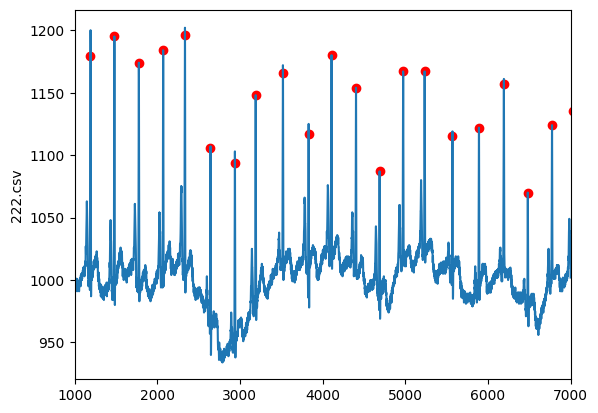

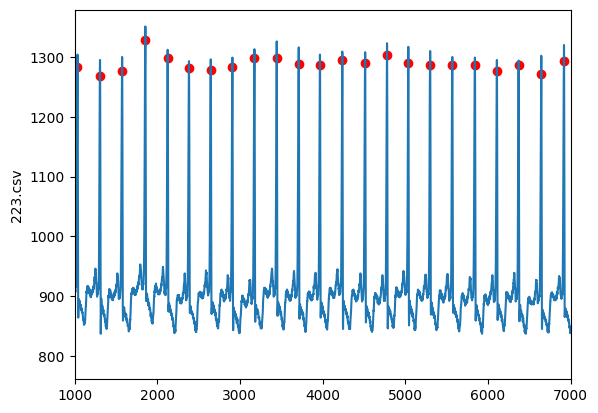

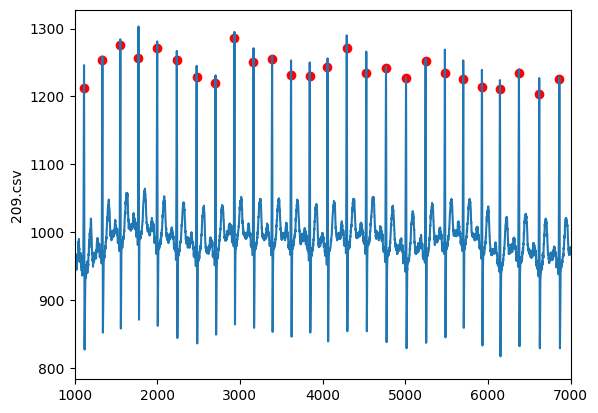

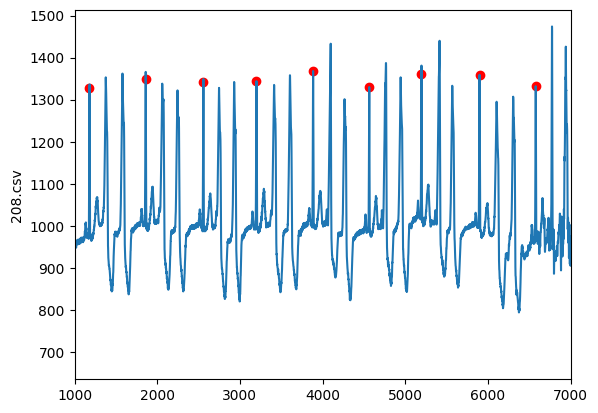

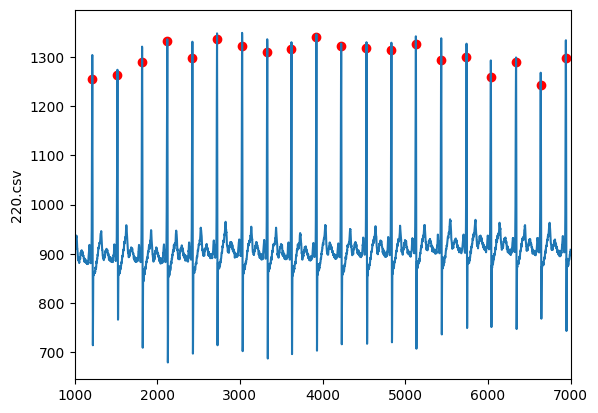

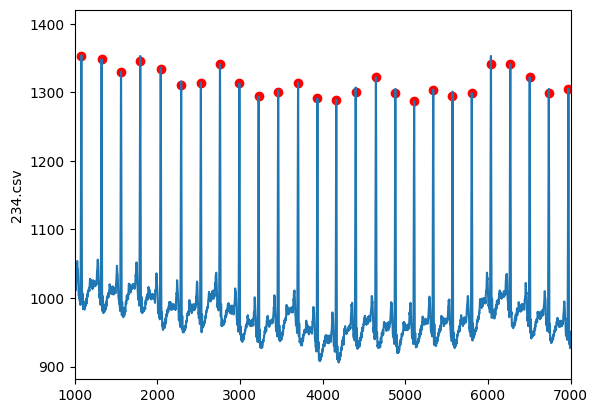

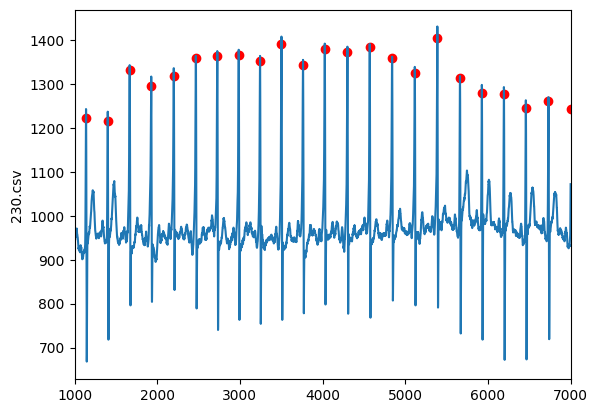

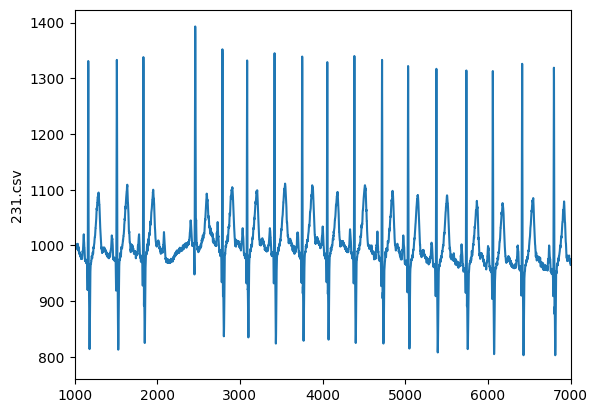

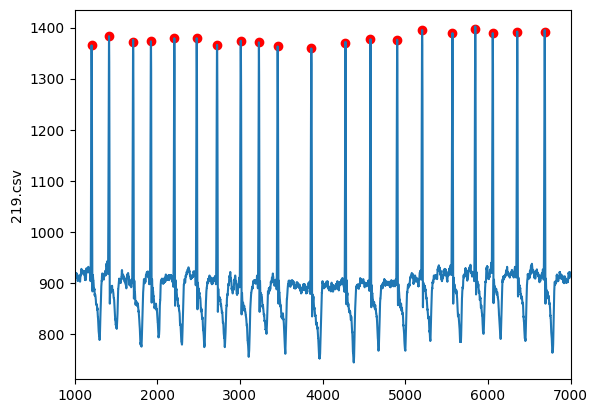

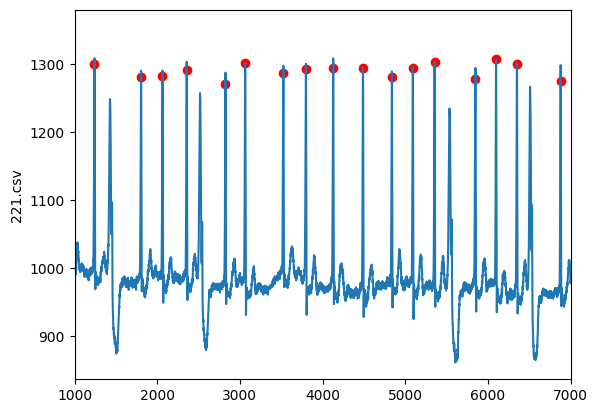

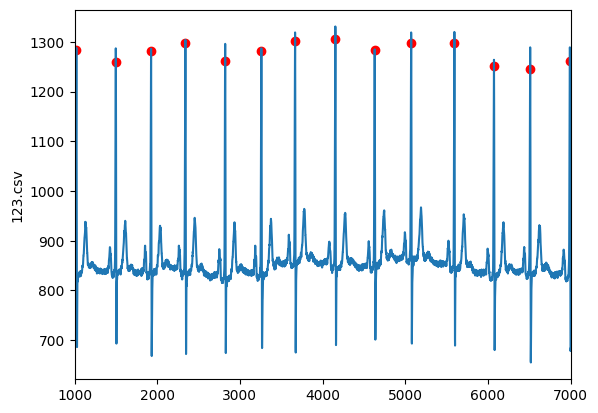

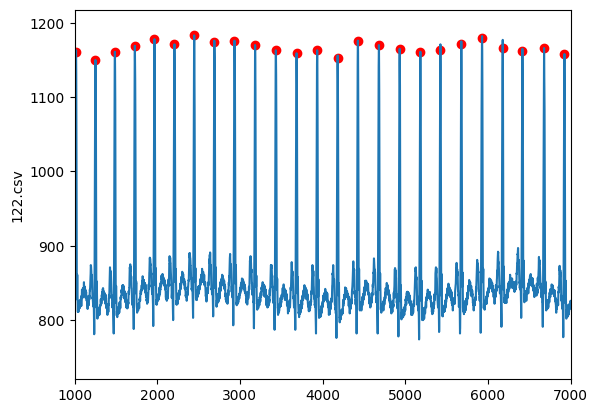

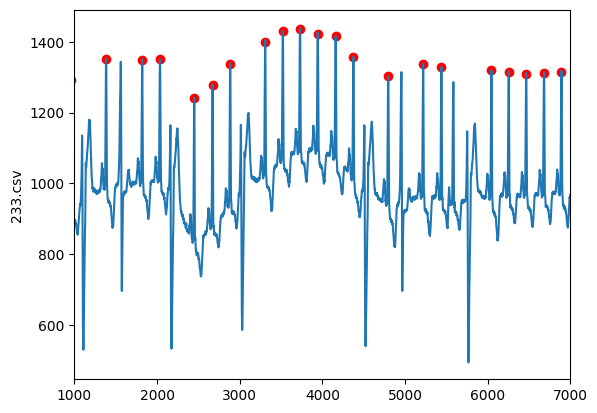

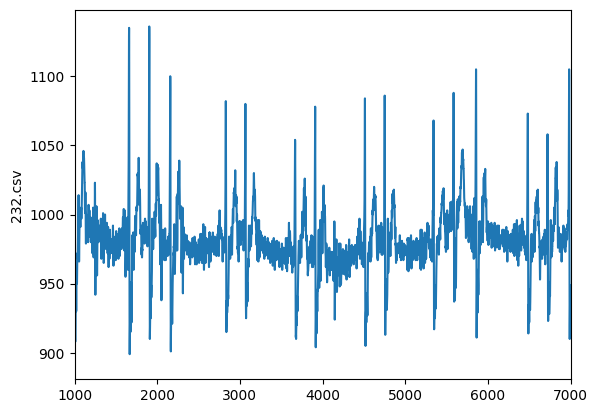

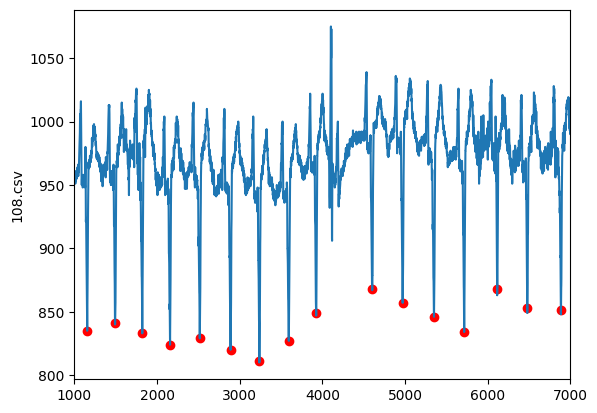

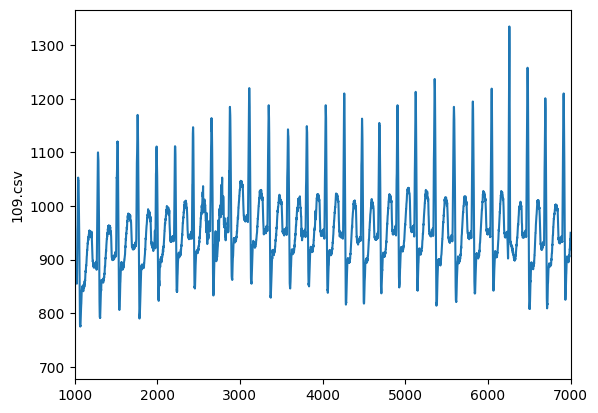

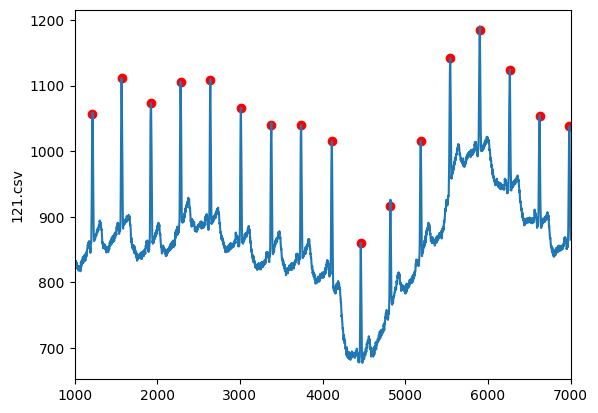

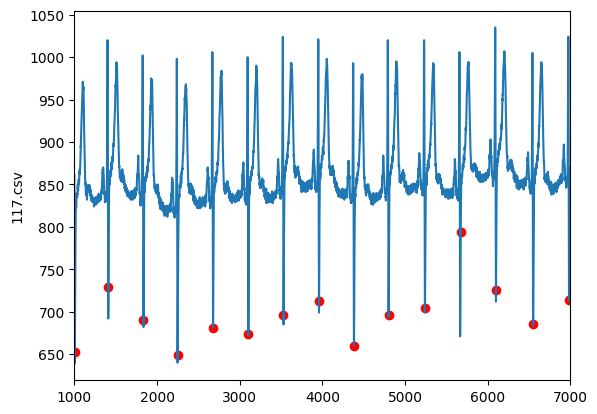

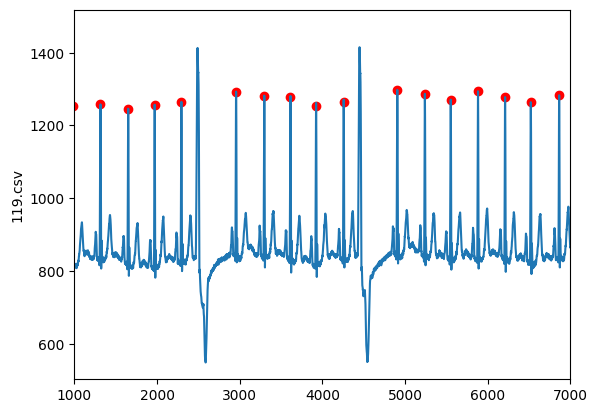

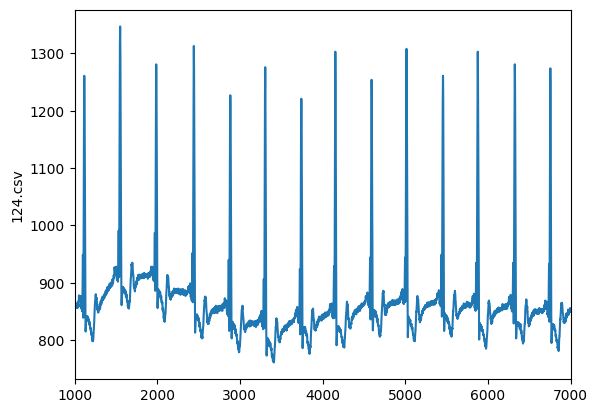

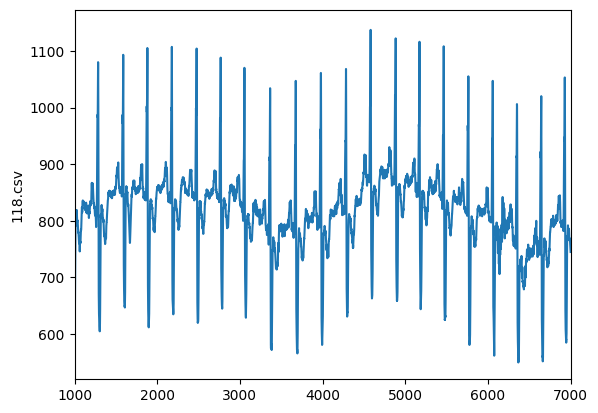

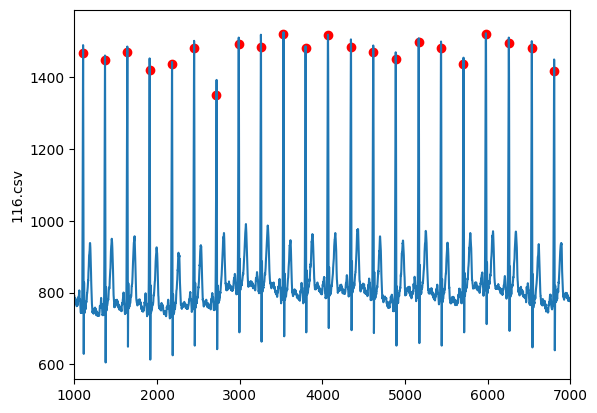

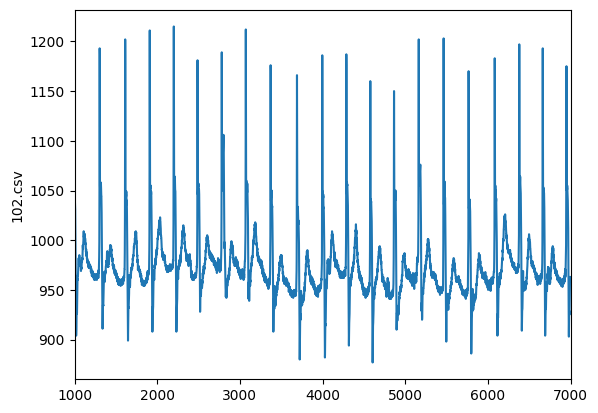

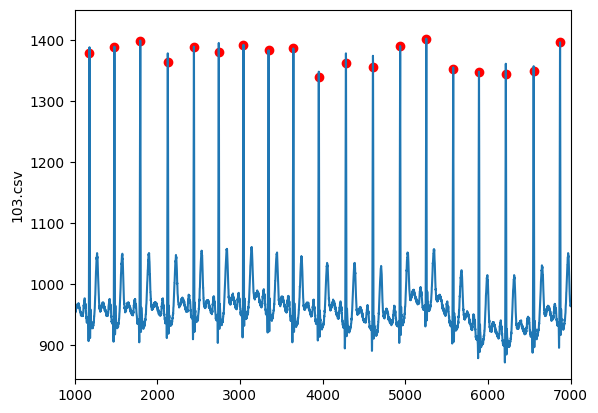

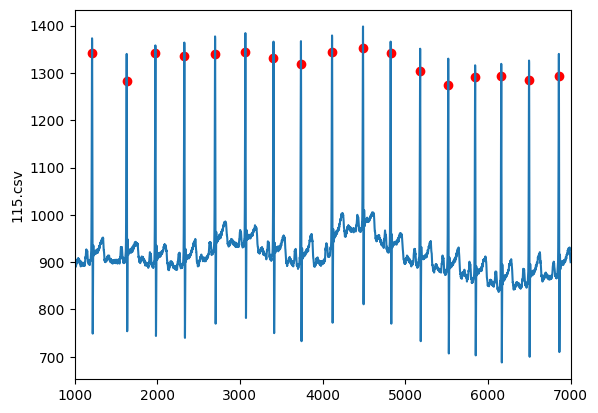

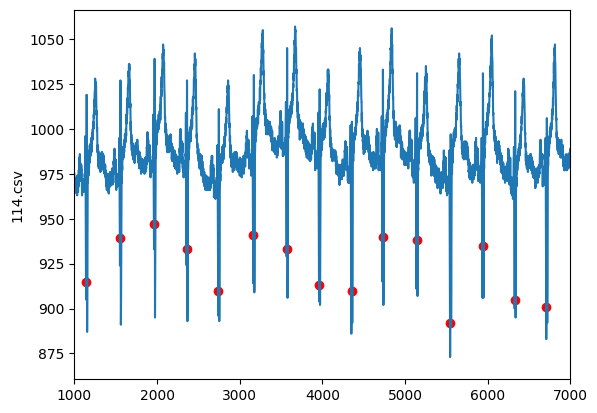

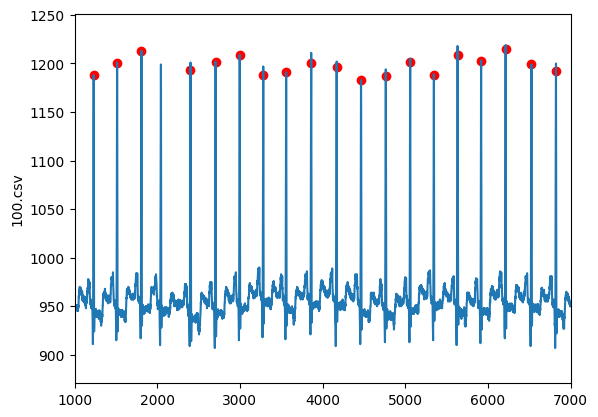

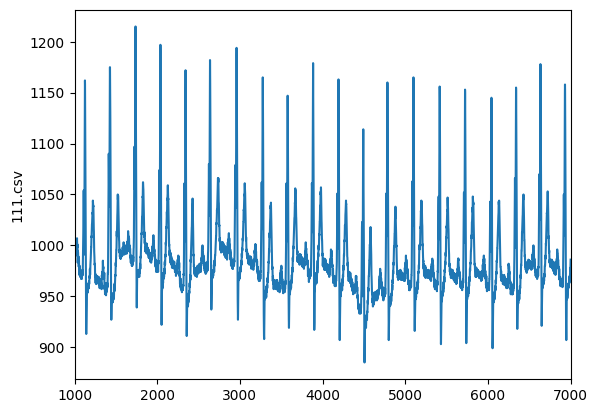

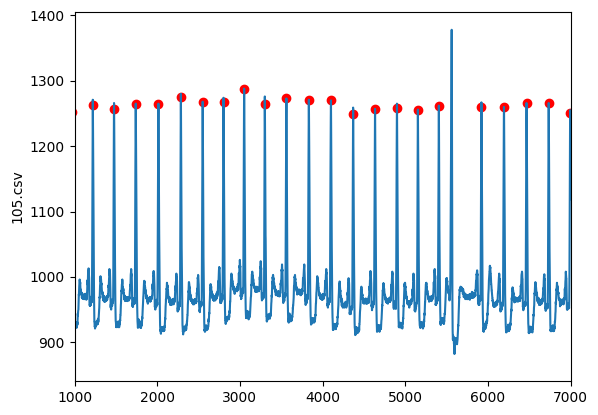

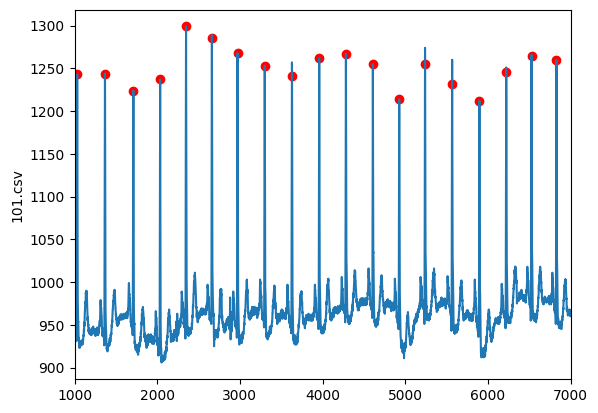

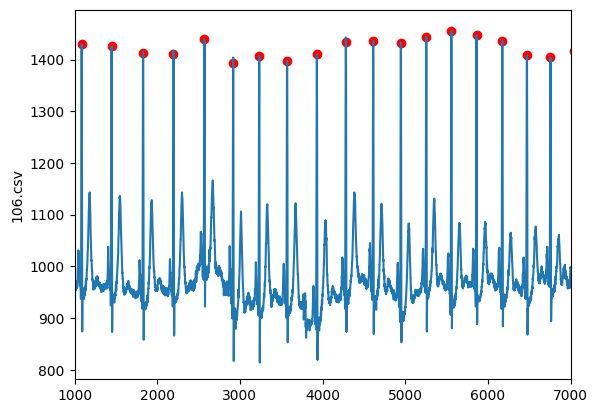

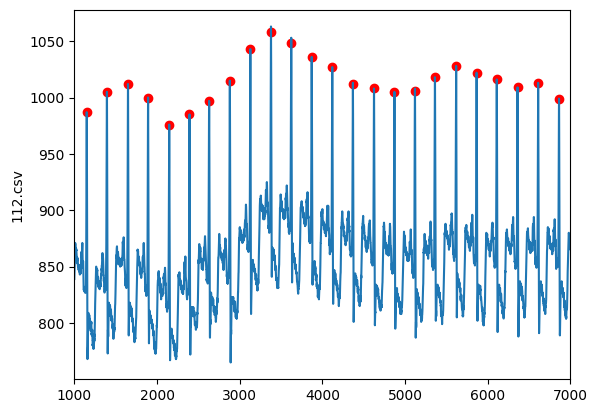

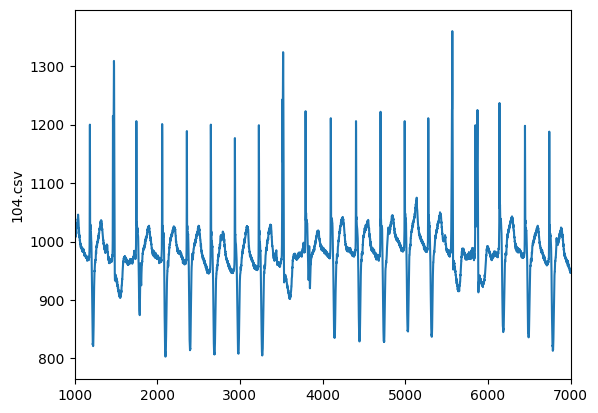

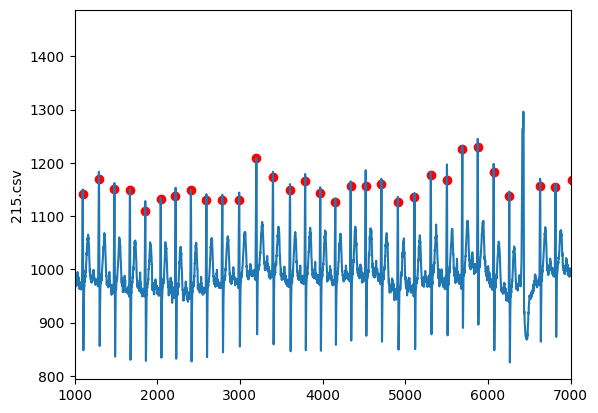

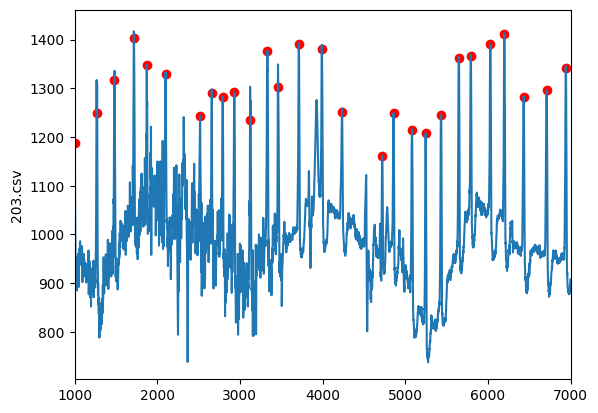

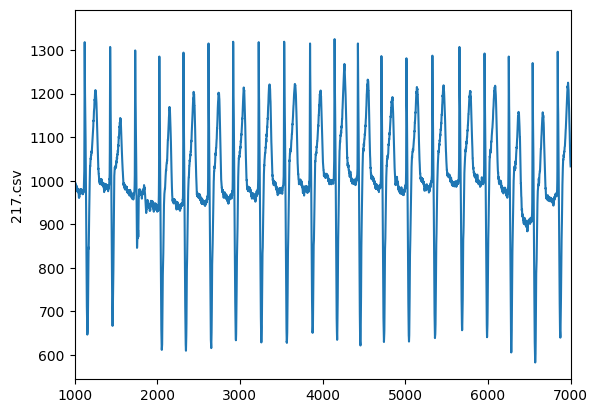

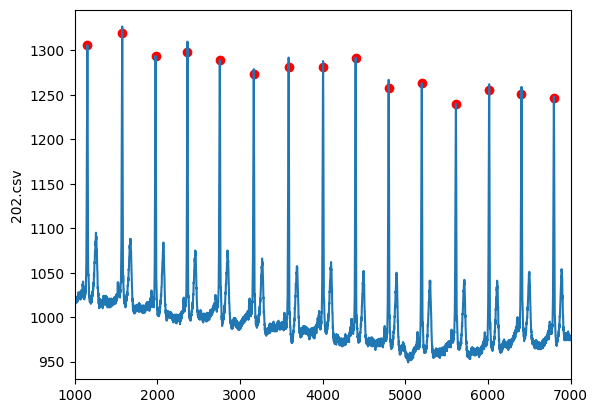

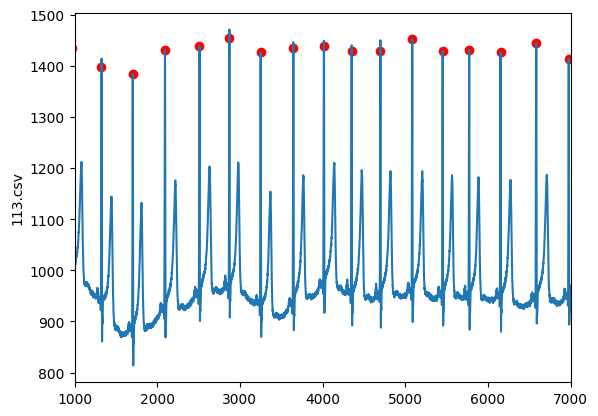

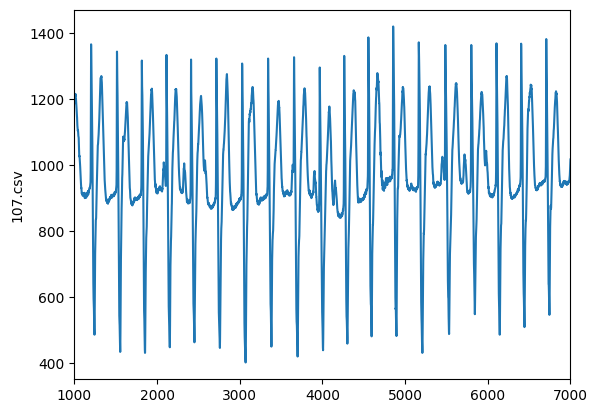

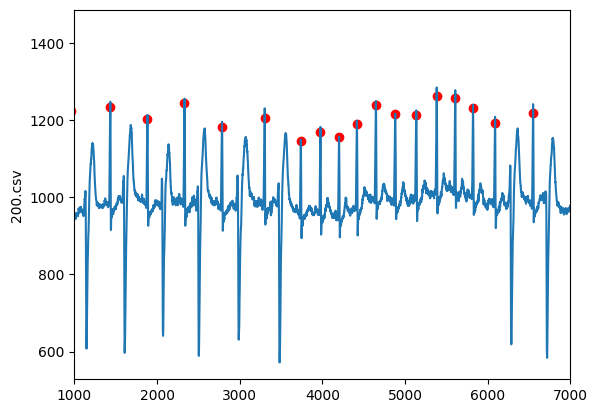

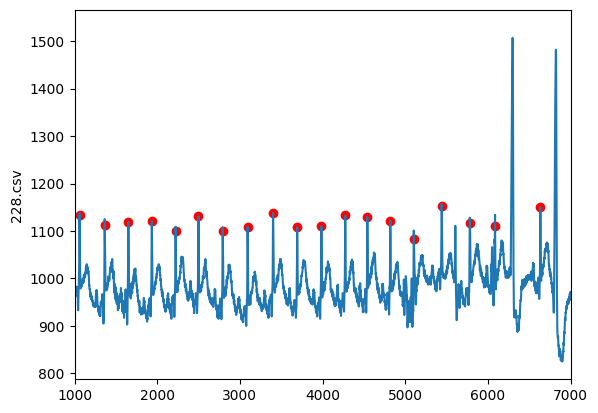

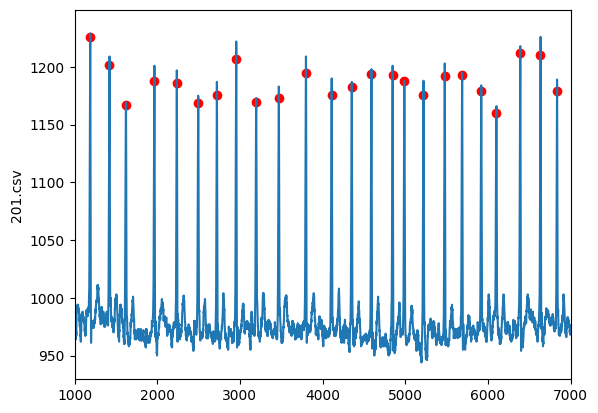

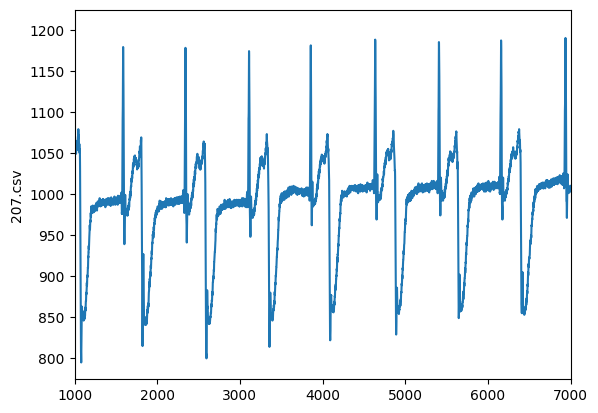

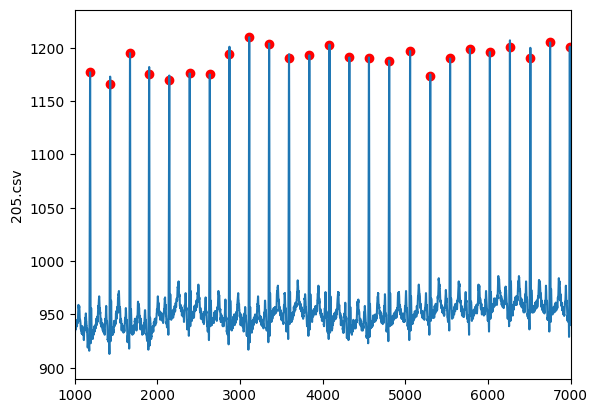

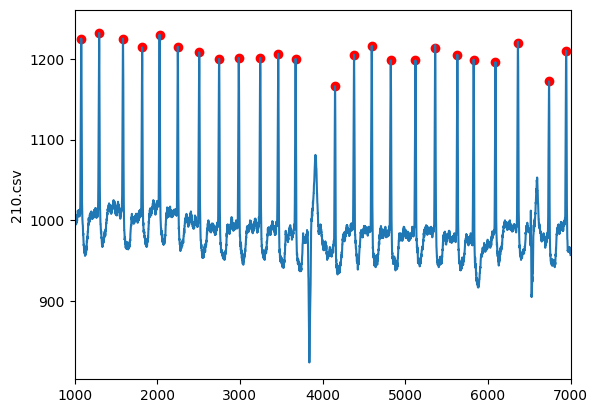

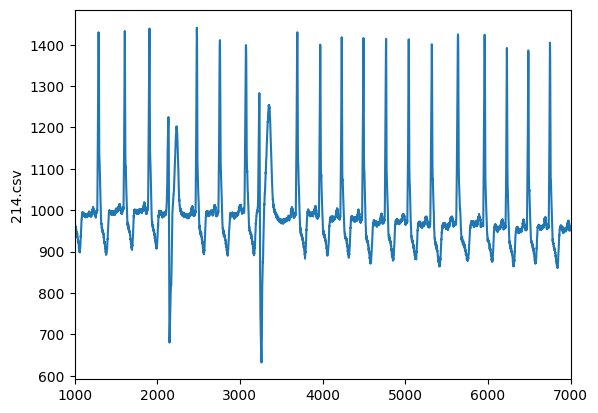

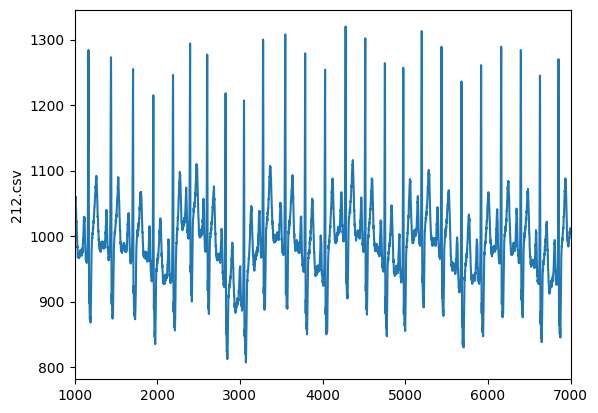

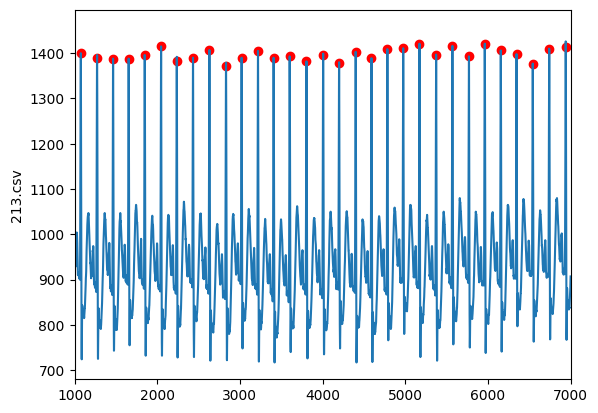

In [ ]:
signal_len = 10000  # Длина сигнала
window = 150  # Размер окна
step = 6  # Шаг

all_data = []  # Список для хранения данных
all_data_label = []  # Список для хранения меток классов

path_data = '/content/gdrive/MyDrive/Colab Notebooks/Time series/mitbih_database'  # Путь к данным

for file in os.listdir(path_data):

  if ('csv' in file):
    print(file)
    path = os.path.join(path_data, file)

    # Получение пути к файлу аннотаций
    annotation_file_path = os.path.join(path_data, file.split('.')[0] + 'annotations.txt')

    data = pd.read_csv(path, nrows = signal_len)
    signal = data[data.columns[1]]

    file_an = open(annotation_file_path)  # Открытие файла с аннотациями
    Lines = file_an.readlines()
    peaks = []
    for L in Lines:
      if bool(re.findall('\d+\s+[N.]\s+', L)) : #записываем метки только для нормальных R зубцов
        temp = int(re.findall('\d+\s+[N.]\s+', L)[0].split(' ')[0])
        if (temp < signal_len):
          peaks.append(temp)
        else:
          break

    plt.figure()
    plt.plot(signal)
    plt.scatter(peaks, signal[peaks], color='red')
    plt.xlim([1000, 7000])

    plt.ylabel(file)

    dataset = []

    for i in range(0, len(signal)-window, step):
        piece = signal[i:i+window] / np.max(np.abs(signal[i:i+window]))
        piece = piece - np.mean(piece)
        is_peak = 0
        middle = (i + i + window) / 2
        for peak in peaks:
            if peak >= middle - step//2 and peak < middle + step//2:
                is_peak = 1
                break
        piece = np.append(piece, is_peak)
        dataset.append(piece)


    df = pd.DataFrame(dataset)
    df[window].sum()
    all_data.append(df)
    all_data_label.append([file[0], file[0:3]])

In [ ]:
all_data_label = np.array(all_data_label)

In [ ]:
# Подбор random state (разбиение выборки) по лучшему F1 и худшему F1 на тестовой выборке
r_s_max = 0
r_s_min = 0
F1_max = 0
F1_min = 1

for r_s in range(0,100,4):
  #r_s=13
  #разобьем данные по пациентам: метки: 1 - пациенты стационара, 2 - амбулаторные пациенты
  X_train_by_p, X_test_by_p, Y_train_by_p, Y_test_by_p = train_test_split(all_data, pd.DataFrame(all_data_label).iloc[:,0], test_size = 0.3, random_state=r_s)

  #объединение данных
  temp = pd.concat(X_train_by_p)
  #print(temp.head())

  #перемешаем обучающую выборку (чтобы от одного пациента данные шли не подряд)
  temp = temp.sample(frac = 1, axis = 0, random_state=42)
  X_train = temp.iloc[: , :window]
  Y_train = temp[window]

  X_test = pd.concat(X_test_by_p).iloc[: , :window]
  Y_test = pd.concat(X_test_by_p)[window]

  booster = CatBoost(params = {'iterations':500, 'learning_rate':0.01, 'loss_function':'Logloss', 'verbose': False})#, 'max_depth':6

  booster.fit(X_train, Y_train.astype('int'), eval_set=(X_test, Y_test.astype('int')))
  booster.set_feature_names([str(i) for i in range(window)])

  test_preds = booster.predict(X_test, prediction_type="Class")
  train_preds = booster.predict(X_train, prediction_type="Class")

  print('\nr_s=', r_s)
  print("Test  F1 : %f"%eval_metric(Y_test.values, test_preds, "F1")[0])
  print("Test  Recall : %f"%eval_metric(Y_test.values, test_preds, "Recall")[0])
  print("Test  Precision : %f"%eval_metric(Y_test.values, test_preds, "Precision")[0])
  print("Test  Accuracy : %f"%eval_metric(Y_test.values, test_preds, "Accuracy")[0])

  print("Train  F1 : %f"%eval_metric(Y_train.values, train_preds, "F1")[0])
  print("Train  Recall : %f"%eval_metric(Y_train.values, train_preds, "Recall")[0])
  print("Train  Precision : %f"%eval_metric(Y_train.values, train_preds, "Precision")[0])
  print("Train Accuracy : %f"%eval_metric(Y_train.values, train_preds, "Accuracy")[0])
  if eval_metric(Y_test.values, test_preds, "F1")[0] > F1_max:
    F1_max = eval_metric(Y_test.values, test_preds, "F1")[0]
    r_s_max = r_s

  if eval_metric(Y_test.values, test_preds, "F1")[0] < F1_min:
    F1_min = eval_metric(Y_test.values, test_preds, "F1")[0]
    r_s_min = r_s



r_s= 0
Test  F1 : 0.727802
Test  Recall : 0.589623
Test  Precision : 0.950570
Test  Accuracy : 0.992408
Train  F1 : 0.958942
Train  Recall : 0.937415
Train  Precision : 0.981481
Train Accuracy : 0.998911

r_s= 4
Test  F1 : 0.727794
Test  Recall : 0.586605
Test  Precision : 0.958491
Test  Accuracy : 0.992286
Train  F1 : 0.971268
Train  Recall : 0.954545
Train  Precision : 0.988588
Train Accuracy : 0.999243

r_s= 8
Test  F1 : 0.621212
Test  Recall : 0.478972
Test  Precision : 0.883621
Test  Accuracy : 0.989850
Train  F1 : 0.935231
Train  Recall : 0.898769
Train  Precision : 0.974777
Train Accuracy : 0.998321

r_s= 12
Test  F1 : 0.657439
Test  Recall : 0.808511
Test  Precision : 0.553936
Test  Accuracy : 0.991961
Train  F1 : 0.913636
Train  Recall : 0.870130
Train  Precision : 0.961722
Train Accuracy : 0.997195

r_s= 16
Test  F1 : 0.738703
Test  Recall : 0.610390
Test  Precision : 0.935323
Test  Accuracy : 0.994600
Train  F1 : 0.974970
Train  Recall : 0.961222
Train  Precision : 0.989117

# Обучение с максимальным F1

In [ ]:
# Разобьем данные по пациентам: метки: 1 - пациенты стационара, 2 - амбулаторные пациенты
X_train_by_p, X_test_by_p, Y_train_by_p, Y_test_by_p = train_test_split(all_data, pd.DataFrame(all_data_label).iloc[:,0], test_size = 0.3, random_state=r_s_max)

# Объединим данные
temp = pd.concat(X_train_by_p)
#print(temp.head())

# Перемешаем обучающую выборку (чтобы от олногопациента данные шли не подряд)
temp = temp.sample(frac = 1, axis = 0, random_state=42)
X_train = temp.iloc[: , :window]
Y_train = temp[window]

X_test = pd.concat(X_test_by_p).iloc[: , :window]
Y_test = pd.concat(X_test_by_p)[window]

booster = CatBoost(params = {'iterations':1500, 'learning_rate':0.01, 'loss_function':'Logloss', 'verbose': True})#, 'max_depth':6

booster.fit(X_train, Y_train.astype('int'), eval_set=(X_test, Y_test.astype('int')))
booster.set_feature_names([str(i) for i in range(window)])

test_preds = booster.predict(X_test, prediction_type="Class")
train_preds = booster.predict(X_train, prediction_type="Class")

0:	learn: 0.6659790	test: 0.6663984	best: 0.6663984 (0)	total: 250ms	remaining: 6m 14s
1:	learn: 0.6352978	test: 0.6357960	best: 0.6357960 (1)	total: 459ms	remaining: 5m 43s
2:	learn: 0.6107376	test: 0.6108461	best: 0.6108461 (2)	total: 633ms	remaining: 5m 15s
3:	learn: 0.5850232	test: 0.5848189	best: 0.5848189 (3)	total: 857ms	remaining: 5m 20s
4:	learn: 0.5580671	test: 0.5581101	best: 0.5581101 (4)	total: 1.07s	remaining: 5m 21s
5:	learn: 0.5326016	test: 0.5329201	best: 0.5329201 (5)	total: 1.31s	remaining: 5m 26s
6:	learn: 0.5054294	test: 0.5051219	best: 0.5051219 (6)	total: 1.59s	remaining: 5m 38s
7:	learn: 0.4851815	test: 0.4847410	best: 0.4847410 (7)	total: 1.82s	remaining: 5m 39s
8:	learn: 0.4667485	test: 0.4663719	best: 0.4663719 (8)	total: 2.05s	remaining: 5m 39s
9:	learn: 0.4487197	test: 0.4480646	best: 0.4480646 (9)	total: 2.32s	remaining: 5m 45s
10:	learn: 0.4295660	test: 0.4286685	best: 0.4286685 (10)	total: 2.56s	remaining: 5m 46s
11:	learn: 0.4081444	test: 0.4071336	best

In [ ]:
print('\nНаилучшие показатели:')
print('r_s=', r_s)
print("Test  F1 : %f"%eval_metric(Y_test.values, test_preds, "F1")[0])
print("Test  Recall : %f"%eval_metric(Y_test.values, test_preds, "Recall")[0])
print("Test  Precision : %f"%eval_metric(Y_test.values, test_preds, "Precision")[0])
print("Test  Accuracy : %f"%eval_metric(Y_test.values, test_preds, "Accuracy")[0])

print("Train  F1 : %f"%eval_metric(Y_train.values, train_preds, "F1")[0])
print("Train  Recall : %f"%eval_metric(Y_train.values, train_preds, "Recall")[0])
print("Train  Precision : %f"%eval_metric(Y_train.values, train_preds, "Precision")[0])
print("Train Accuracy : %f"%eval_metric(Y_train.values, train_preds, "Accuracy")[0])

print(f'Наилучшие показатели получились при наличии в обучающей выборке {len(X_train_by_p)} сигналов из {len(X_train_by_p)+len(X_test_by_p)} при длине сигналов {signal_len}')
best_train = [all_data_label[i,1] for i in Y_train_by_p.index]
best_test = [all_data_label[i,1] for i in Y_test_by_p.index]
print(f'Содержание выборок: \nTrain: {best_train}\nTest: {best_test}')


Наилучшие показатели:
r_s= 96
Test  F1 : 0.927536
Test  Recall : 0.881543
Test  Precision : 0.978593
Test  Accuracy : 0.997970
Train  F1 : 0.996226
Train  Recall : 0.994975
Train  Precision : 0.997481
Train Accuracy : 0.999889
Наилучшие показатели получились при наличии в обучающей выборке 33 сигналов из 48 при длине сигналов 10000
Содержание выборок: 
Train: ['108', '207', '117', '104', '201', '208', '114', '214', '118', '203', '209', '202', '107', '200', '222', '215', '228', '223', '105', '219', '121', '233', '116', '101', '231', '100', '109', '234', '106', '113', '123', '124', '115']
Test: ['119', '210', '220', '221', '212', '232', '230', '102', '111', '122', '217', '103', '112', '213', '205']


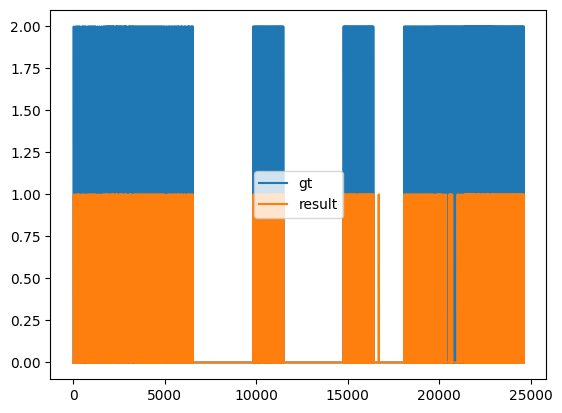

In [ ]:
plt.plot(Y_test.values*2, label='gt')
plt.plot(test_preds, label='result')
#plt.xlim([0, 1])
plt.legend()

# Обучение с минимальным F1

In [ ]:
# Разобьем данные по пациентам: метки: 1 - пациенты стационара, 2 - амбулаторные пациенты
X_train_by_p, X_test_by_p, Y_train_by_p, Y_test_by_p = train_test_split(all_data, pd.DataFrame(all_data_label).iloc[:,0], test_size = 0.3, random_state=r_s_min)

# Объединим данные
temp = pd.concat(X_train_by_p)
#print(temp.head())

# Перемешаем обучающую выборку (чтобы от олногопациента данные шли не подряд)
temp = temp.sample(frac = 1, axis = 0, random_state=42)
X_train = temp.iloc[: , :window]
Y_train = temp[window]

X_test = pd.concat(X_test_by_p).iloc[: , :window]
Y_test = pd.concat(X_test_by_p)[window]

booster = CatBoost(params = {'iterations':250, 'learning_rate':0.01, 'loss_function':'Logloss', 'verbose': True})#, 'max_depth':6

booster.fit(X_train, Y_train.astype('int'), eval_set=(X_test, Y_test.astype('int')))
booster.set_feature_names([str(i) for i in range(window)])

test_preds = booster.predict(X_test, prediction_type="Class")
train_preds = booster.predict(X_train, prediction_type="Class")

0:	learn: 0.6620852	test: 0.6624479	best: 0.6624479 (0)	total: 148ms	remaining: 36.9s
1:	learn: 0.6323064	test: 0.6328830	best: 0.6328830 (1)	total: 286ms	remaining: 35.5s
2:	learn: 0.6071213	test: 0.6082777	best: 0.6082777 (2)	total: 418ms	remaining: 34.4s
3:	learn: 0.5784267	test: 0.5799937	best: 0.5799937 (3)	total: 553ms	remaining: 34s
4:	learn: 0.5496222	test: 0.5509773	best: 0.5509773 (4)	total: 687ms	remaining: 33.6s
5:	learn: 0.5215938	test: 0.5229863	best: 0.5229863 (5)	total: 806ms	remaining: 32.8s
6:	learn: 0.4963997	test: 0.4979671	best: 0.4979671 (6)	total: 936ms	remaining: 32.5s
7:	learn: 0.4758915	test: 0.4777371	best: 0.4777371 (7)	total: 1.06s	remaining: 32s
8:	learn: 0.4553702	test: 0.4575574	best: 0.4575574 (8)	total: 1.18s	remaining: 31.6s
9:	learn: 0.4365661	test: 0.4387098	best: 0.4387098 (9)	total: 1.43s	remaining: 34.3s
10:	learn: 0.4166382	test: 0.4189285	best: 0.4189285 (10)	total: 1.65s	remaining: 35.8s
11:	learn: 0.3941074	test: 0.3966513	best: 0.3966513 (11

In [ ]:
print('\nХудшие показатели:')
print('r_s=', r_s)
print("Test  F1 : %f"%eval_metric(Y_test.values, test_preds, "F1")[0])
print("Test  Recall : %f"%eval_metric(Y_test.values, test_preds, "Recall")[0])
print("Test  Precision : %f"%eval_metric(Y_test.values, test_preds, "Precision")[0])
print("Test  Accuracy : %f"%eval_metric(Y_test.values, test_preds, "Accuracy")[0])

print("Train  F1 : %f"%eval_metric(Y_train.values, train_preds, "F1")[0])
print("Train  Recall : %f"%eval_metric(Y_train.values, train_preds, "Recall")[0])
print("Train  Precision : %f"%eval_metric(Y_train.values, train_preds, "Precision")[0])
print("Train Accuracy : %f"%eval_metric(Y_train.values, train_preds, "Accuracy")[0])

print(f'Худшие показатели получились при наличии в обучающей выборке {len(X_train_by_p)} сигналов из {len(X_train_by_p)+len(X_test_by_p)} при длине сигналов {signal_len}')
worst_train = [all_data_label[i,1] for i in Y_train_by_p.index]
worst_test = [all_data_label[i,1] for i in Y_test_by_p.index]
print(f'Содержание выборок: \nTrain: {worst_train}\nTest: {worst_test}')


Худшие показатели:
r_s= 96
Test  F1 : 0.621212
Test  Recall : 0.478972
Test  Precision : 0.883621
Test  Accuracy : 0.989850
Train  F1 : 0.935231
Train  Recall : 0.898769
Train  Precision : 0.974777
Train Accuracy : 0.998321
Худшие показатели получились при наличии в обучающей выборке 33 сигналов из 48 при длине сигналов 10000
Содержание выборок: 
Train: ['202', '210', '212', '106', '209', '113', '107', '231', '105', '200', '220', '214', '217', '115', '215', '230', '108', '119', '101', '109', '221', '232', '111', '123', '116', '228', '124', '219', '100', '234', '201', '118', '208']
Test: ['207', '213', '203', '102', '205', '103', '117', '222', '121', '114', '104', '233', '122', '223', '112']


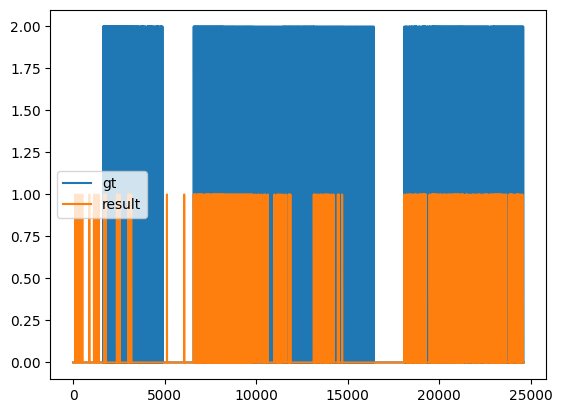

In [ ]:
plt.plot(Y_test.values*2, label='gt')
plt.plot(test_preds, label='result')
#plt.xlim([0, 1])
plt.legend()

In [ ]:
#Попробуем обяснить, почему получились такие результаты по разбиениям
#считаем размеченные файлы
file_name = [] #файл с разметкой
peaks_label_ = [] #список по всем файлам характерных элементов ЭКГ
path_data = '/content/gdrive/MyDrive/Colab Notebooks/Time series/mitbih_database'
for file in os.listdir(path_data):
  if ('txt' in file): # файлы с разметкой имеют раширение txt, а с сигналами csv
    peaks_label = [] #что за характерный элемент ЭКГ (обозначения распиcаны здесь: https://www.physionet.org/files/mitdb/1.0.0/mitdbdir/intro.htm#symbols)
    path = os.path.join(path_data, file)
    file_an = open(path)
    Lines = file_an.readlines()
    peaks = []
    for L in Lines:
      if bool(re.findall('\d+\s+[N.LRAaJSVF\[!\]ejE//fxQ|]\s+', L)) :
        peaks_label.append(re.findall('\s[N.LRAaJSVF\[!\]ejE//fxQ|]\s', L)[0][1]) #записываем метку характерного элемента ЭКГ
        temp = int(re.findall('\d+\s+[N.LRAaJSVF\[!\]ejE//fxQ|]\s+', L)[0].split(' ')[0])#ищем число (номер отсчета в сигнале, к которому относитс данных элемент ЭКГ)
        if temp<signal_len:
          peaks.append(temp) #записываем номер отсчета в список
        #print(re.findall('\s[N.LRAaJSVF\[!\]ejE//fxQ|]\s', L)[0][1])
        else:
          break

    peaks_label_.append(peaks_label)
    file_name.append(file)
peaks_label_ = np.array(peaks_label_)

<ipython-input-20-e380dd535275>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  peaks_label_ = np.array(peaks_label_)


In [ ]:
print('Какие характерные элементы ЭКГ встречаются в каждом файле:')
for i in range(len(peaks_label_)):
  print(file_name[i][0:3], ': ', np.unique(peaks_label_[i], return_counts=True))

Какие характерные элементы ЭКГ встречаются в каждом файле:
208 :  (array(['F', 'N', 'V'], dtype='<U1'), array([ 7, 22, 19]))
215 :  (array(['N', 'V'], dtype='<U1'), array([50,  3]))
214 :  (array(['L', 'V'], dtype='<U1'), array([34,  2]))
213 :  (array(['N'], dtype='<U1'), array([52]))
210 :  (array(['F', 'N', 'V'], dtype='<U1'), array([ 1, 40,  3]))
205 :  (array(['N'], dtype='<U1'), array([42]))
121 :  (array(['N'], dtype='<U1'), array([29]))
212 :  (array(['R'], dtype='<U1'), array([43]))
122 :  (array(['N'], dtype='<U1'), array([42]))
217 :  (array(['/', 'f'], dtype='<U1'), array([33,  1]))
219 :  (array(['N'], dtype='<U1'), array([34]))
123 :  (array(['N'], dtype='<U1'), array([23]))
102 :  (array(['/'], dtype='<U1'), array([35]))
117 :  (array(['N'], dtype='<U1'), array([24]))
230 :  (array(['N'], dtype='<U1'), array([39]))
203 :  (array(['N', 'V'], dtype='<U1'), array([46,  4]))
105 :  (array(['N', 'V'], dtype='<U1'), array([37,  2]))
103 :  (array(['N'], dtype='<U1'), array([33

In [ ]:
# Перегруппируем файлы по наличию в них определенных элементов ЭКГ
set_peaks = []
for p in peaks_label_:
  set_peaks+=list(set(p))
file_for_extract = []
for label in set(set_peaks):
  file_with_label = []
  if  set_peaks.count(label):
    for i in range(len(peaks_label_)):
      if label in peaks_label_[i]:
        file_with_label.append(file_name[i][0:3])
    print(label,': ', set_peaks.count(label), file_with_label)
    file_for_extract+=(file_with_label)

x :  1 ['108']
f :  2 ['217', '104']
F :  3 ['208', '210', '109']
/ :  4 ['217', '102', '104', '107']
A :  3 ['233', '100', '232']
| :  1 ['228']
N :  35 ['208', '215', '213', '210', '205', '121', '122', '219', '123', '117', '230', '203', '105', '103', '233', '116', '114', '202', '222', '119', '221', '101', '223', '112', '113', '228', '100', '234', '220', '115', '106', '108', '209', '201', '200']
R :  6 ['212', '118', '124', '231', '232', '207']
V :  14 ['208', '215', '214', '210', '203', '105', '233', '119', '221', '223', '228', '108', '207', '200']
a :  1 ['113']
L :  3 ['214', '109', '111']


In [ ]:
# Отличающиеся файлы в двух разбиениях:
# A - B Возвращает разность множеств A и B (элементы, входящие в A, но не входящие в B).
print('В лучшем train есть, а в худшем нет: ', set(best_train)-set(worst_train))
print('В худшем train есть, а в лучшем нет: ',set(worst_train)-set(best_train))
print('\nВ лучшем test есть, а в худшем нет: ', set(best_test)-set(worst_test))
print('В худшем test есть, а в лучшем нет: ',set(worst_test)-set(best_test))

В лучшем train есть, а в худшем нет:  {'203', '104', '223', '114', '207', '117', '222', '121', '233'}
В худшем train есть, а в лучшем нет:  {'119', '212', '217', '221', '210', '220', '111', '232', '230'}

В лучшем test есть, а в худшем нет:  {'119', '212', '217', '221', '210', '220', '111', '232', '230'}
В худшем test есть, а в лучшем нет:  {'203', '104', '223', '114', '207', '117', '222', '121', '233'}


Видно, что попадение в тестовую выборку большого количества файлов с
элементами ЭКГ, которые по форме похожи на R-зубцы, но не являются ими (имеют метку не N)
объясняет падение метрик.
Так, (смотрим по несовпадающим файлам) в худшем случае в тестовую выборку
попало 6 таких файлов(208, 231, 124, 119, 100, 210),
а в лучшем случае только 3 (221, 107, 105), кроме того, в 221 и 105 есть только 6 и 2 элементов V соответсвенно.

На метрики по train выборке попадение файлов с такими элементами в train не сильно влияет, т.к. её размер существенно больше

Для устранения этой ситуации лучше использовать мультиклассовую классификацию и различать R зубцы не только
от baseline и менее высокочастотных зубцов, но и от аномалий в сигнале, похожих на QRS косплекс

Accuracy не информативен, т.к. классы несблансированы (классов с меткой 0 >>, чем классов с меткой 1)